In [1]:
from __future__ import division

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def classify_circle_data(num_samples=1, noise=0):
    radius = 5
    def get_circle_label(x, y):
        return 1 if (np.sqrt(x**2 + y**2) < (radius * 0.5)) else 0
    points = []
    labels = []
    
    # Generate positive points inside the circle.
    for i in range(num_samples // 2):
        r = np.random.uniform(0, 0.5 * radius)
        angle = np.random.uniform(0, 2 * np.math.pi)
        x = r * np.math.sin(angle)
        y = r * np.math.cos(angle)
        noise_x = np.random.uniform(-radius, radius) * noise;
        noise_y = np.random.uniform(-radius, radius) * noise;
        label = get_circle_label(x + noise_x, y + noise_y)
        points.append([x,y])
        labels.append(label)
        
    # Generate negative points inside the circle.
    for i in range(num_samples // 2):
        r = np.random.uniform(radius * 0.7, radius)
        angle = np.random.uniform(0, 2 * np.math.pi)
        x = r * np.math.sin(angle)
        y = r * np.math.cos(angle)
        noise_x = np.random.uniform(-radius, radius) * noise;
        noise_y = np.random.uniform(-radius, radius) * noise;
        label = get_circle_label(x + noise_x, y + noise_y)
        points.append([x,y])
        labels.append(label)
    
    return np.array(points), np.array(labels)
#         return points, labels

In [4]:
def classify_xor_data(num_samples=1, noise=0):
    radius = 5
    def get_xor_label(x, y):
        return 1 if x * y >= 0 else 0
    points = []
    labels = []
    padding = 0.3
    for i in range(num_samples):
        x = np.random.uniform(-5, 5)
        x += (padding if x >0 else -padding)
        y = np.random.uniform(-5, 5)
        y += (padding if y >0 else -padding)
        noise_x = np.random.uniform(-radius, radius) * noise;
        noise_y = np.random.uniform(-radius, radius) * noise;
        label = get_xor_label(x + noise_x, y + noise_y)
        points.append([x,y])
        labels.append(label)
    return np.array(points), np.array(labels)

In [5]:
def classify_spiral_data(num_samples=1, noise=0):
    points = []
    labels = []
    n = num_samples // 2
    def gen_spiral(deltaT, label):
        for i in range(n):
            r = i / n * 5
            t = 1.75 * i / n * 2 * np.math.pi + deltaT
            x = r * np.math.sin(t) + np.random.uniform(-1, 1) * noise
            y = r * np.math.cos(t) + np.random.uniform(-1, 1) * noise
            points.append([x,y])
            labels.append(label)
    gen_spiral(0,1)
    gen_spiral(np.math.pi, 0)
    return np.array(points), np.array(labels)

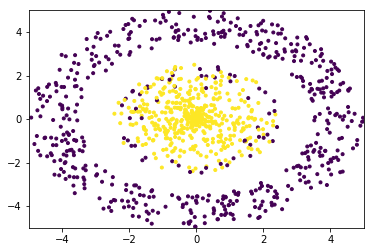

In [6]:
X1, Y1 = classify_circle_data(num_samples=1000, noise=0.2)
plt.scatter(X1[:, 0], X1[:, 1], marker='.', c=Y1)
plt.axis([-5, 5, -5, 5])
plt.show()

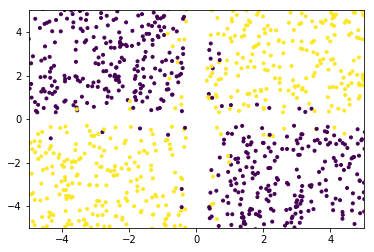

In [7]:
X2, Y2 = classify_xor_data(num_samples=1000, noise=0.2)
plt.scatter(X2[:, 0], X2[:, 1], marker='.', c=Y2)
plt.axis([-5, 5, -5, 5])
plt.show()

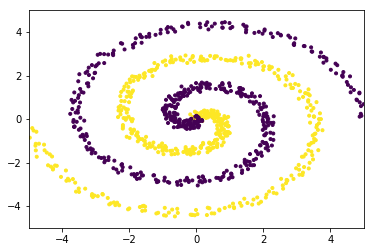

In [8]:
X3, Y3 = classify_spiral_data(num_samples=1000, noise=0.2)
plt.scatter(X3[:, 0], X3[:, 1], marker='.', c=Y3)
plt.axis([-5, 5, -5, 5])
plt.show()

# train code

In [9]:
import tensorflow as tf

In [10]:
BATCH_SIZE = 10     # 每次batch打包的样本个数        

# 模型相关的参数
LEARNING_RATE_BASE = 0.8   # origin learning rate    
LEARNING_RATE_DECAY = 0.99  # decay
REGULARAZTION_RATE = 0.0001  # weight regulazation lambda
TRAINING_STEPS = 500        

In [11]:
def inference(input_tensor, weights1, biases1, weights2, biases2):
    layer1 = tf.nn.relu(tf.matmul(input_tensor, weights1) + biases1)
    return tf.matmul(layer1, weights2) + biases2

In [12]:
def train(data, label, input_node = 2, hid_node = 4, out_node = 2):
    # Input placeholder.
    x = tf.placeholder(tf.float32, [None, input_node], name='x-input') # [batch,input_node]
    y_ = tf.placeholder(tf.float32, [None, out_node], name='y-input') # [batch,2]
    # 生成隐藏层的参数。
    # truncated_normal:截断高斯函数(<2*stddev)　P67,table3-2
    weights1 = tf.Variable(tf.truncated_normal([input_node, hid_node], stddev=0.1)) # [2,4]
    biases1 = tf.Variable(tf.constant(0.1, shape=[hid_node]))
    # 生成输出层的参数。
    weights2 = tf.Variable(tf.truncated_normal([hid_node, out_node], stddev=0.1))
    biases2 = tf.Variable(tf.constant(0.1, shape=[out_node]))

    # 计算前向传播结果
    y = inference(x, weights1, biases1, weights2, biases2)
    print ("y.shape: ", y.shape)
    # 计算交叉熵及其平均值
    # tf.nn.softmax_cross_entropy_with_logits() = softmax + cross_entropy
    # 在只有一个答案的分类问题中，只用`sparse_softmax_cross_entropy_with_logits`加速计算
    # 1
#     cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y, labels=y_)
    # loss = -1/n*sum(y*log(y^)+(1-y)*log(1-y^)
    # 2
#     cross_entropy = -tf.reduce_mean(y_ * tf.log(tf.clip_by_value(y, 1e-10, 1.0))
#                                 + (1 - y_) * tf.log(tf.clip_by_value(1 - y, 1e-10, 1.0)))
#     cross_entropy_mean = tf.reduce_mean(cross_entropy)
    # 3
    y_one_hot = tf.one_hot(label, 2)
    cross_entropy =tf.nn.softmax_cross_entropy_with_logits(logits = y, labels = y_one_hot)
    
    # 损失函数的计算
    regularizer = tf.contrib.layers.l2_regularizer(REGULARAZTION_RATE)
    regularaztion = regularizer(weights1) + regularizer(weights2)
    # Total loss
    loss = cross_entropy + regularaztion
    
    # 定义训练轮数及相关的滑动平均类 
    global_step = tf.Variable(0, trainable=False)
    # 设置指数衰减的学习率。
    learning_rate = tf.train.exponential_decay(
        LEARNING_RATE_BASE, # starter learning rate
        global_step,
        1000 / BATCH_SIZE, # decay_steps, # 衰减速度
        LEARNING_RATE_DECAY,
        staircase=True)
    
    # 优化损失函数
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
   
    # 计算正确率
    # tf.argmax: Returns the index with the largest value across axes of a tensor.
    # tf.equal: Returns the truth value of (x == y) element-wise.
    # correct_prediction.shape: [batch_size,1]
#     correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1)) # axis=1,along colums
#     accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) # A float number.
    
    # 初始化会话，并开始训练过程。
    with tf.Session() as sess:
        tf.global_variables_initializer().run() # Init all variables
#         validate_feed = {x: mnist.validation.images, y_: mnist.validation.labels}
#         test_feed = {x: mnist.test.images, y_: mnist.test.labels} 
        
        # 循环的训练神经网络。
        for i in range(TRAINING_STEPS):
#             if i % 1000 == 0:
#                 validate_acc = sess.run(accuracy, feed_dict=validate_feed)
#                 print("After %d training step(s), validation accuracy using average model is %g " % (i, validate_acc))
            # Feed train data.
            start = (i*BATCH_SIZE) % 1000 # batch start, not over the total length 128.
            end = (i*BATCH_SIZE) % 1000 + BATCH_SIZE # batch end.
#             sess.run(train_step,feed_dict={x:data[start:end], y_:label[start:end]})
            _, los = sess.run([train_step, loss], feed_dict={x:data, y_:y_one_hot})
#         test_acc=sess.run(accuracy,feed_dict=test_feed)
#         print(("After %d training step(s), test accuracy using average model is %g" %(TRAINING_STEPS, test_acc)))
            if i% 100 == 0:
                print(("After %d training step(s), loss is: %f." % (i, los)))

In [13]:
# circle data.
print ("X1[:10] ", X1[:10])
print ("X1.shape: ", X1.shape)
print ("Y1[:10] ", Y1[:10])
# Y1 = tf.expand_dims(Y1, 1)
# np.reshape(Y1, [1000, 1])
print ("Y1.shape: ", Y1.shape)
# Y1.reshape(1000,1)
# one_hot

train(X1, Y1, out_node = 2)

X1[:10]  [[ 0.19969703 -0.23332779]
 [-0.02979051 -0.08145232]
 [ 0.03699585 -0.05245415]
 [ 0.45312378  1.47125826]
 [-0.72102141 -1.94003939]
 [-0.0900079   0.97278904]
 [-0.31194278  0.40362039]
 [ 0.26851393 -0.04676641]
 [ 0.04037648 -0.07037918]
 [-1.13442947  0.78361137]]
X1.shape:  (1000, 2)
Y1[:10]  [1 1 1 1 0 1 1 1 1 1]
Y1.shape:  (1000,)
y.shape:  (?, 2)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



TypeError: The value of a feed cannot be a tf.Tensor object. Acceptable feed values include Python scalars, strings, lists, numpy ndarrays, or TensorHandles.For reference, the tensor object was Tensor("one_hot:0", shape=(1000, 2), dtype=float32) which was passed to the feed with key Tensor("y-input:0", shape=(?, 2), dtype=float32).